### This document has been adapted for the Harvard tinyML course from the Arduino gesture regonition tutorial.



##Credit
Tiny ML on Arduino: Gesture recognition tutorial
 * Sandeep Mistry - Arduino
 * Don Coleman - Chariot Solutions

 
https://github.com/arduino/AIoT-Dev-Summit-2019

## Setup Python Environment 

Install up the Python libraries and Linux tools for the code in the notebook.

In [2]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
%tensorflow_version 2.x
!pip install tensorflow

Selecting previously unselected package xxd.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.4_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.4) ...
Setting up xxd (2:8.0.1453-1ubuntu1.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


# Upload Data

1. Navigate to the folders tab on the left
2. Upload the .csv files from the gestures/ folder of the assignment repo

# Graphing Data

The following code visualizes a one second sample of the accelerometer and gyroscope input which is captured at 119 Hz. This is an example of the data that will be passed to the neural network.

Change the filename from handwash.csv to other.csv. If you were given these samples to classify, what patterns would you look for?



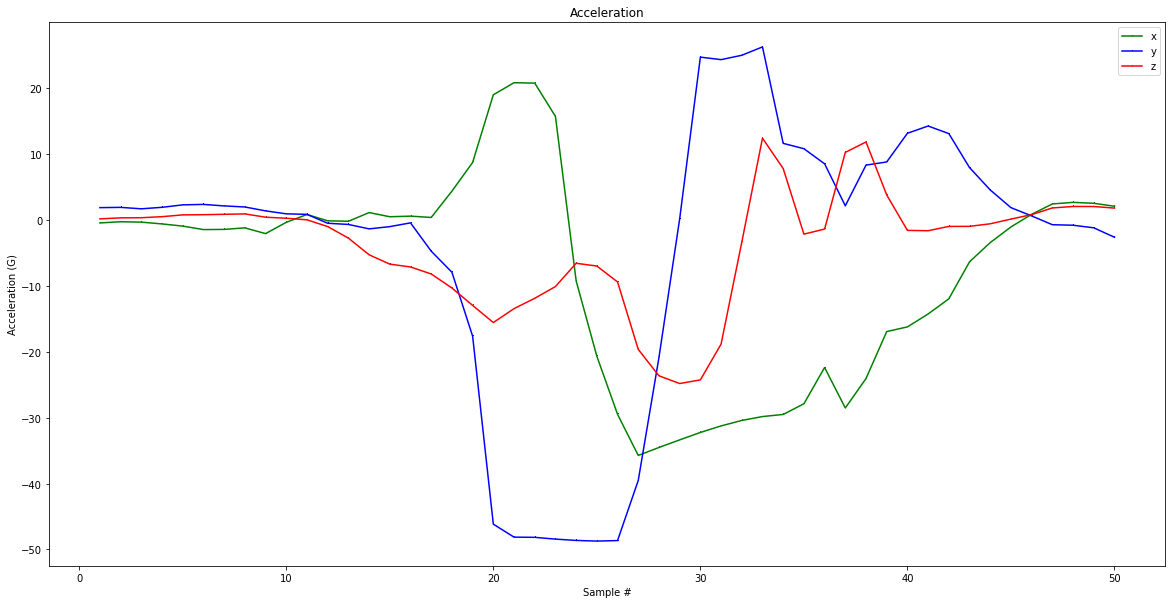

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "/content/strum.csv"

SAMPLES_PER_GESTURE = 50

df = pd.read_csv(filename)

index = range(1, SAMPLES_PER_GESTURE+1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['ax'][:SAMPLES_PER_GESTURE], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['ay'][:SAMPLES_PER_GESTURE], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['az'][:SAMPLES_PER_GESTURE], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

# plt.plot(index, df['gX'][:SAMPLES_PER_GESTURE], 'g.', label='x', linestyle='solid', marker=',')
# plt.plot(index, df['gY'][:SAMPLES_PER_GESTURE], 'b.', label='y', linestyle='solid', marker=',')
# plt.plot(index, df['gZ'][:SAMPLES_PER_GESTURE], 'r.', label='z', linestyle='solid', marker=',')
# plt.title("Gyroscope")
# plt.xlabel("Sample #")
# plt.ylabel("Gyroscope (deg/sec)")
# plt.legend()
# plt.show()


# Train Neural Network





## Parse and prepare the data

Parse the CSV files and transforms them to a format that can be used to train the neural network.

**Take note** two gestures have been commented out. Uncomment "back_of_hand_washing" and "thumb_twist_hand_wash" after you have tested the first model on the device.



In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures 
GESTURES = [
    "strum",
    "no_strum"
]

SAMPLES_PER_GESTURE = 50

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# get min and max values
min_num = 99999
max_num = -999999
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  df = pd.read_csv("/content/"+gesture+".csv")
  df.dropna()
  df.reset_index(drop=True)
  min_num = min(min_num, min(df['ax']), min(df['ay']), min(df['az']))
  max_num = max(max_num, max(df['ax']), max(df['ay']), max(df['az']))

print("Min number is ", min_num)
print("Max number is ", max_num)
# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv("/content/" + gesture + ".csv")

  # get rid of pesky empty value lines of csv which cause NaN inputs to TensorFlow
  df = df.dropna()
  df = df.reset_index(drop=True)
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['ax'][index] - min_num) / (max_num - min_num),
          (df['ay'][index] - min_num) / (max_num - min_num),
          (df['az'][index] - min_num) / (max_num - min_num)
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.3.0

Min number is  -48.89
Max number is  41.48
Processing index 0 for gesture 'strum'.
	There are 388 recordings of the strum gesture.
Processing index 1 for gesture 'no_strum'.
	There are 336 recordings of the no_strum gesture.
Data set parsing and preparation complete.


## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [5]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

**TAKE NOTE** Our first version of the model is a very small three layer FC model. Later (after we add "back_of_hand_washing" and "thumb_twist_hand_wash") this will not be enough to get the performance we want so we will have to scale it up.

In [6]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(30, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
# the final layer is softmax because we only expect one gesture to occur per input
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax'))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae', 'accuracy'])

history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Epoch 1/600
434/434 [==============================] - 1s 3ms/step - loss: 0.2369 - mae: 0.4773 - accuracy: 0.5876 - val_loss: 0.1983 - val_mae: 0.4375 - val_accuracy: 0.8082
Epoch 2/600
434/434 [==============================] - 1s 2ms/step - loss: 0.1840 - mae: 0.3978 - accuracy: 0.7327 - val_loss: 0.1640 - val_mae: 0.3709 - val_accuracy: 0.8082
Epoch 3/600
434/434 [==============================] - 1s 2ms/step - loss: 0.1554 - mae: 0.3284 - accuracy: 0.7788 - val_loss: 0.1677 - val_mae: 0.3504 - val_accuracy: 0.7671
Epoch 4/600
434/434 [==============================] - 1s 3ms/step - loss: 0.1444 - mae: 0.2951 - accuracy: 0.7857 - val_loss: 0.1422 - val_mae: 0.2883 - val_accuracy: 0.8151
Epoch 5/600
434/434 [==============================] - 1s 2ms/step - loss: 0.1392 - mae: 0.2809 - accuracy: 0.8018 - val_loss: 0.1462 - val_mae: 0.2894 - val_accuracy: 0.8082
Epoch 6/600
434/434 [==============================] - 1s 3ms/step - loss: 0.1372 - mae: 0.2633 - accuracy: 0.8018 - val_loss

## Verify 

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

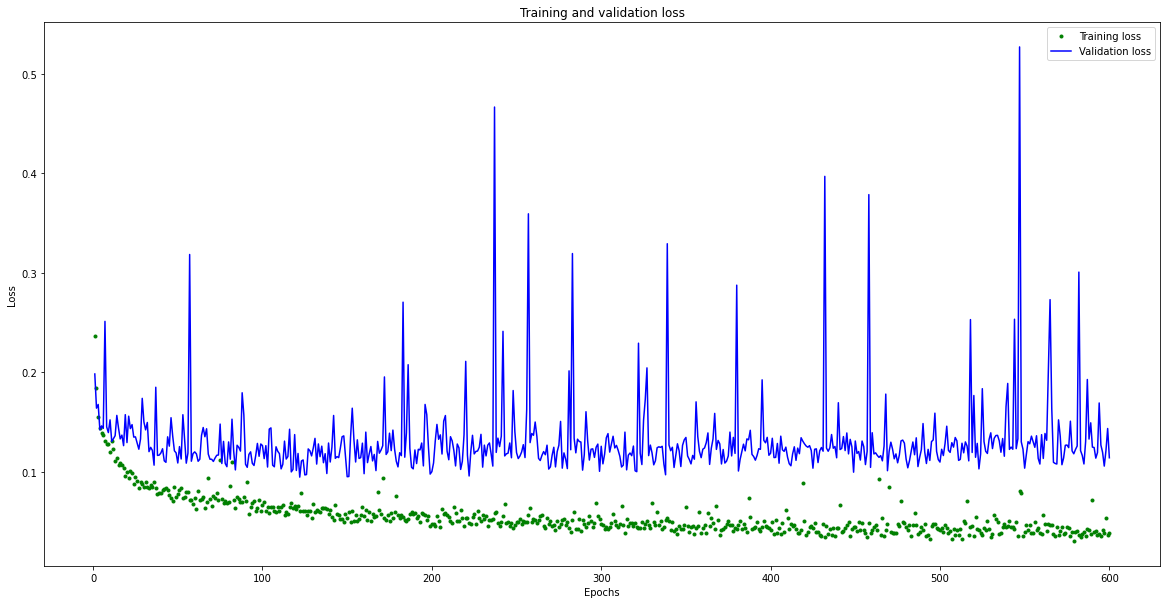

[20.0, 10.0]


In [7]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Graph the loss again, skipping a bit of the start

We'll graph the same data as the previous code cell, but start at index 100 so we can further zoom in once the model starts to converge.

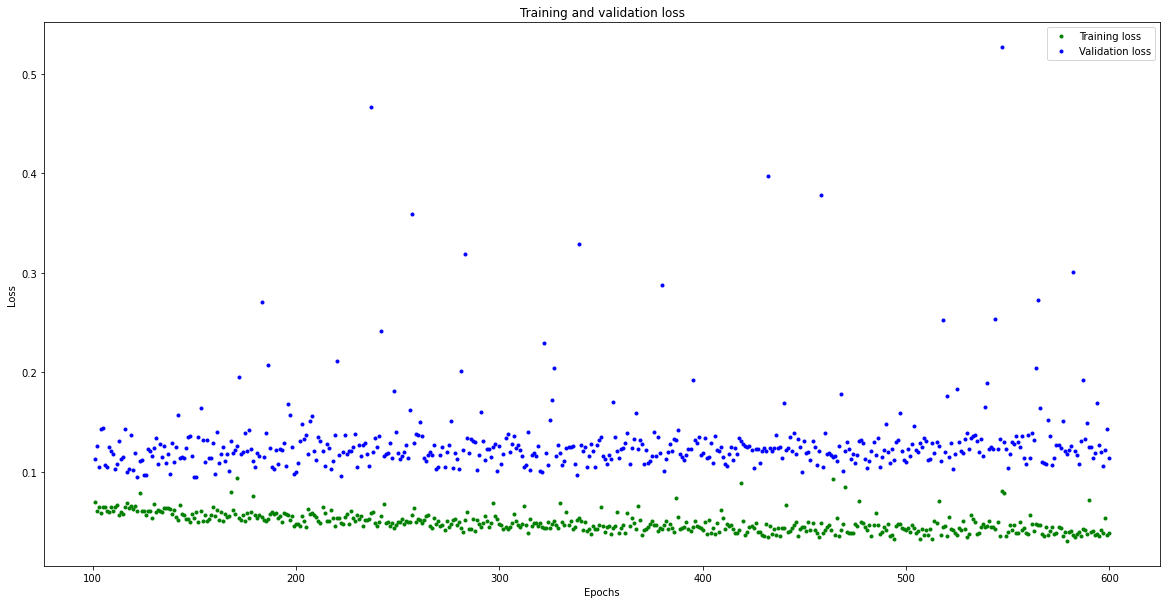

In [8]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Graph the mean absolute error

[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) is another metric to judge the performance of the model.



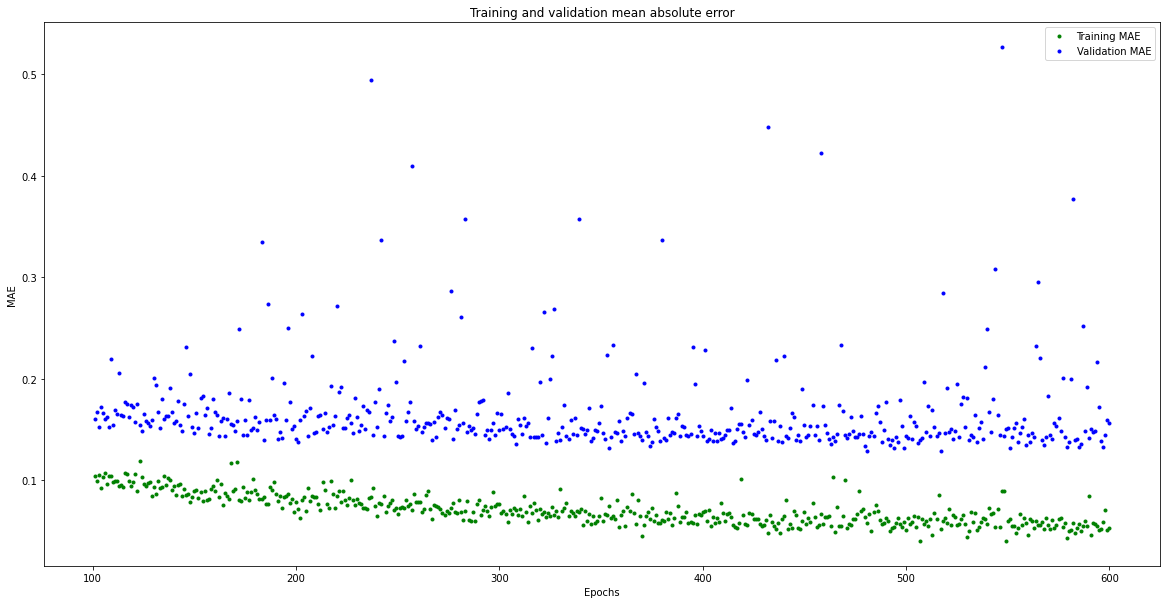

In [9]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


### Run with Test Data
Put our test data into the model and compare the predictions vs actual output

*The confusion matrix* is a useful tool for understanding misclassifications.

The columns represent the labels predicted by the model and the rows represent the groud truth labels.

This can be a great tool to understand the balence and fairness of your model. For example, if a column has only zeros then the model is never guessing that label.

**Take Note** You will submit the output of this cell

Training accuracy:  0.9562212228775024
Validation accuracy:  0.8630136847496033


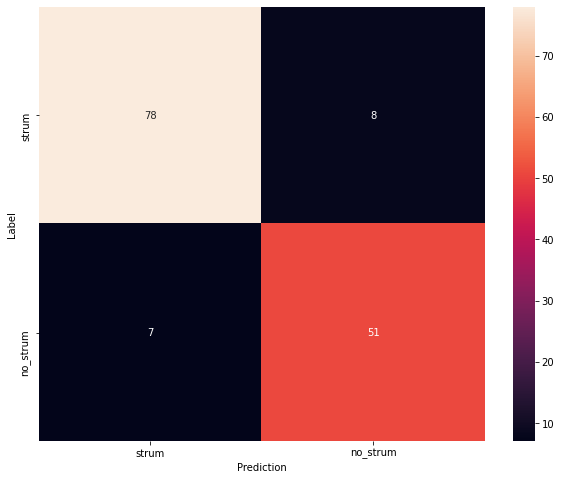

In [10]:
import seaborn as sns

# use the model to predict the test inputs
predictions = model.predict(inputs_test)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

print('Training accuracy: ', acc[-1])
print('Validation accuracy: ', val_acc[-1])

def index_of_max(output_list):
  #takes a list of list
  #returns a list of the index of the max of the sub lists
  list_of_indicies = []
  for sub_list in output_list:
    list_of_indicies.append(np.argmax(sub_list))
  return list_of_indicies

confusion = tf.math.confusion_matrix(
    labels=tf.constant(index_of_max(outputs_test)),
    predictions=tf.constant(index_of_max(predictions)),
    num_classes=NUM_GESTURES)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, xticklabels=GESTURES, yticklabels=GESTURES, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. 

The size of the model is printed out in bytes. When you eventually make modifications to the model it will impact this number.

**TAKE NOTE** You will have to submit the model size

In [11]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpq86ua6ra/assets
Model is 21688 bytes


## Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

**TAKE NOTE** You will have to submit the header file size

In [12]:
!apt-get update
!apt-get -qq install xxd

!echo "const unsigned char model[] __attribute__((aligned(4))) = {"  > /content/model.h
!cat gesture_model.tflite | xxd -i                                  >> /content/model.h
!echo "};"                                                          >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [40.7 kB]
Get:12 http://ppa.launchpad.net/graph

# Classifying IMU Data

Now it's time to switch back to the instructions and run our new model on the Arduino Nano 33 BLE Sense to classify the accelerometer and gyroscope data.
